In [1]:
# IMPORTS:
import os, sys
import numpy as np
import tensorflow as tf

import voxelmorph as vxm
import neurite as ne

2023-02-20 14:48:09.371996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download MRI Data:
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2023-02-20 14:48:36--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16644702 (16M) [application/x-gzip]
Saving to: 'data.tar.gz'

data.tar.gz         100%[===================>]  15.87M  8.41MB/s    in 1.9s    

2023-02-20 14:48:39 (8.41 MB/s) - 'data.tar.gz' saved [16644702/16644702]

x brain_2d_no_smooth.h5
x brain_2d_smooth.h5
x brain_3d.h5
x fs_rgb.npy
x subj1.npz
x subj2.npz
x tutorial_data.npz


In [3]:
# LOAD DATA:
npz = np.load('data/tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

print("Train Shape: ", x_train.shape) # 208 volumes are of size 160x192

Train Shape:  (208, 192, 160)


### VISUALIZE RAW DATA

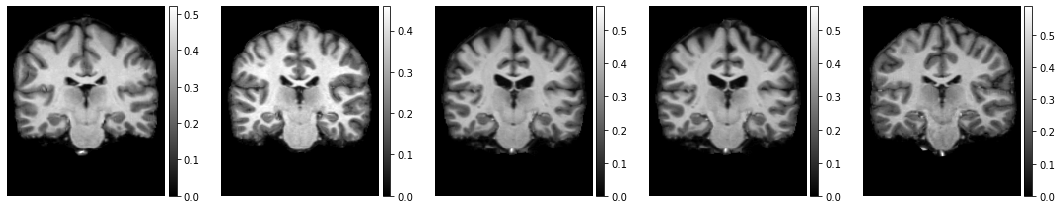

(<Figure size 1080x216 with 10 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

In [4]:
# grab from data
idx = np.random.randint(0, x_train.shape[0], [5,])
examps = [f for f in x_train[idx, ...]]

# plot
ne.plot.slices(examps, cmaps = ['gray'], do_colorbars = True)

### RUN PREDICTIONS/REGISTRATION ON PRETRAINED MODEL

In [10]:
# CONFIGURE UNET-LIKE MODEL
ndim = 2

nb_feat = [
    [32, 32, 32, 32],           # encoder
    [32, 32, 32, 32, 32, 16]    # decoder
]

vxm_model = vxm.networks.VxmDense(x_train.shape[1:], nb_feat, int_steps = 0)

# LOSS
losses = ['mse', vxm.losses.Grad('12').loss]
loss_weights = [1, 0.01]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
# COMPILE
vxm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = losses, loss_weights = loss_weights)

In [13]:
# Data Generator Creation
def vxm_data_generator(x_data, batch_size = 32):
    # preliminary sizing:
    vol_shape = x_data.shape[1:]
    ndims = len(vol_shape)

    # prepare zero array for deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs
        idx1 = np.random.randint(0, x_data.shape[0], size = batch_size)
        moving = x_data[idx1, ..., np.newaxis]

        idx2 = np.random.randint(0, x_data.shape[0], size = batch_size)
        fixed = x_data[idx2, ..., np.newaxis]

        inputs = [moving, fixed]

        outputs = [fixed, zero_phi]

        yield (inputs, outputs)

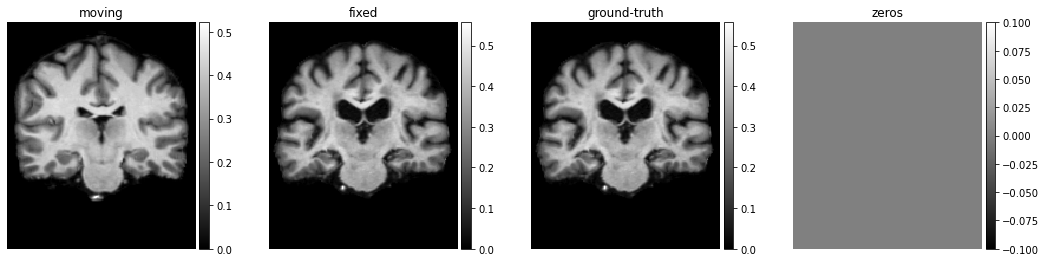

(<Figure size 1080x270 with 8 Axes>,
 array([<AxesSubplot:title={'center':'moving'}>,
        <AxesSubplot:title={'center':'fixed'}>,
        <AxesSubplot:title={'center':'ground-truth'}>,
        <AxesSubplot:title={'center':'zeros'}>], dtype=object))

In [14]:
train_gen = vxm_data_generator(x_train, batch_size = 8)
in_sample, out_sample = next(train_gen)

# VISUALIZE
imgs = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'ground-truth', 'zeros']
ne.plot.slices(imgs, titles = titles, cmaps = ['gray'], do_colorbars = True)

In [15]:
# LOAD PRETRAINED WEIGHTS
vxm_model.load_weights('data/brain_2d_smooth.h5')

In [16]:
# Create validation set
val_gen = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_gen)

In [17]:
# MAKE PREDICTION
val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 1s 1s/step


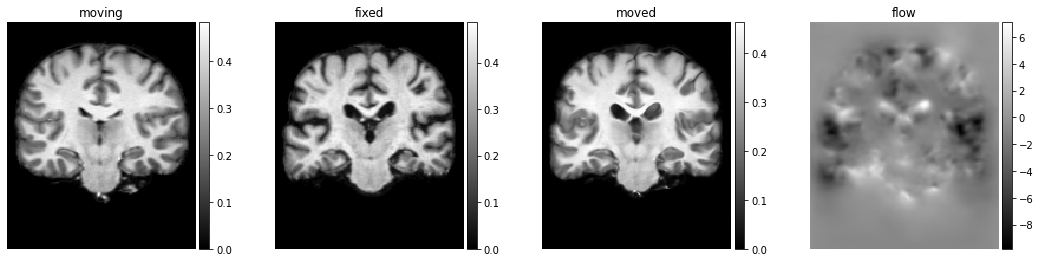

(<Figure size 1080x270 with 8 Axes>,
 array([<AxesSubplot:title={'center':'moving'}>,
        <AxesSubplot:title={'center':'fixed'}>,
        <AxesSubplot:title={'center':'moved'}>,
        <AxesSubplot:title={'center':'flow'}>], dtype=object))

In [18]:
# VISUALIZE REGISTRATION
# VISUALIZE
vimgs = [vimg[0, :, :, 0] for vimg in val_input + val_pred]
vtitles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(vimgs, titles = vtitles, cmaps = ['gray'], do_colorbars = True)

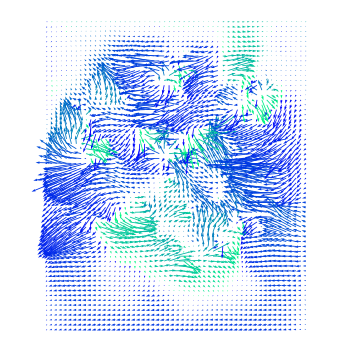

(<Figure size 360x360 with 1 Axes>, [<AxesSubplot:>])

In [19]:
# VISUALIZE FLOW
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width = 5)